# Position Bot

## Import

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from collections import defaultdict, namedtuple, deque, Counter

import warnings
warnings.filterwarnings('ignore')

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DATA_PATH = 'data/'
#raw data from #https://www.kaggle.com/mczielinski/bitcoin-historical-data/version/14
RAW_PATH = f'{DATA_PATH}bitcoin-historical-data/'

## Data Processing

In [2]:
bitstamp_df = pd.read_csv(f'{RAW_PATH}bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
bitstamp_df.columns = ['timestamp','open','high','low','close','vol_btc','vol_usd','vwap']
#select only columns we're interested
bitstamp_df = bitstamp_df[['timestamp','open','high','low','close','vwap']]
#select only portions of timestamps we're interested
bitstamp_df = bitstamp_df.iloc[-1000000:,:]
#for price reference
bitstamp_original = bitstamp_df.copy()
bitstamp_df.shape

(1000000, 6)

In [3]:
bitstamp_df.head()

,timestamp,open,high,low,close,vwap
2405857,1470057660,623.11,623.13,623.11,623.13,623.122474
2405858,1470057720,623.00,623.00,623.00,623.00,623.000000
2405859,1470057780,623.13,623.13,623.13,623.13,623.130000
2405860,1470057840,622.67,623.13,622.67,623.13,623.010421
2405861,1470057900,623.13,623.13,623.13,623.13,623.130000


In [4]:
bitstamp_df.tail()

,timestamp,open,high,low,close,vwap
3405852,1530057360,6061.61,6079.52,6060.99,6079.52,6075.509043
3405853,1530057420,6078.44,6080.11,6067.64,6071.83,6072.944713
3405854,1530057480,6079.15,6085.53,6070.10,6084.69,6076.815504
3405855,1530057540,6082.21,6086.86,6068.00,6068.00,6076.408637
3405856,1530057600,6073.99,6075.41,6064.56,6070.79,6069.787707


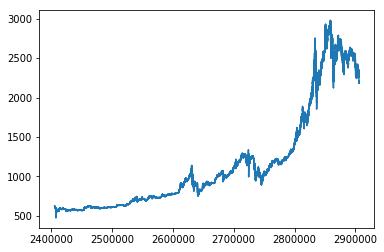

In [5]:
plt.plot(bitstamp_df.vwap[:500000])

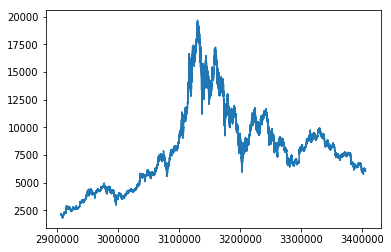

In [6]:
plt.plot(bitstamp_df.vwap[-500000:])

In [7]:
bitstamp_df = bitstamp_df.set_index('timestamp')
#add position; -1, 0, 1 = short, hold, long
bitstamp_df['position'] = 0 
#log difference change
#reward
bitstamp_df['vwap_returns'] = bitstamp_df['vwap'].shift(-1) / bitstamp_df['vwap'] - 1
# bitstamp_df['vwap_returns'] = np.log(bitstamp_df['vwap'].shift(-1)) - np.log(bitstamp_df['vwap'])
#state
bitstamp_df.iloc[:,:5] = bitstamp_df.iloc[:,:5] / bitstamp_df.iloc[:,:5].shift(1) - 1
# bitstamp_df.iloc[:,:5] = np.log(bitstamp_df.iloc[:,:5]) - np.log(bitstamp_df.iloc[:,:5].shift(1))
#commission
bitstamp_df['commission'] = 0
#filter NaN
bitstamp_df = bitstamp_df.iloc[1:-1,:]
bitstamp_df = bitstamp_df.reset_index()

In [8]:
bitstamp_df.tail()

,timestamp,open,high,low,close,vwap,position,vwap_returns,commission
999993,1530057300,-0.001235,-0.000107,-0.000584,0.001803,0.000552,0,0.001215,0
999994,1530057360,-0.000582,0.001240,0.000667,0.001334,0.001215,0,-0.000422,0
999995,1530057420,0.002776,0.000097,0.001097,-0.001265,-0.000422,0,0.000637,0
999996,1530057480,0.000117,0.000891,0.000405,0.002118,0.000637,0,-0.000067,0
999997,1530057540,0.000503,0.000219,-0.000346,-0.002743,-0.000067,0,-0.001090,0


In [9]:
bitstamp_df.head()

,timestamp,open,high,low,close,vwap,position,vwap_returns,commission
0,1470057720,-0.000177,-0.000209,-0.000177,-0.000209,-0.000197,0,2.086677e-04,0
1,1470057780,0.000209,0.000209,0.000209,0.000209,0.000209,0,-1.919006e-04,0
2,1470057840,-0.000738,0.000000,-0.000738,0.000000,-0.000192,0,1.919374e-04,0
3,1470057900,0.000739,0.000000,0.000739,0.000000,0.000192,0,-4.814405e-05,0
4,1470057960,-0.000048,-0.000048,-0.000048,-0.000048,-0.000048,0,2.377628e-07,0


In [10]:
log_returns = (bitstamp_df['vwap_returns']+1)
print(f'Buy and Hold: {(log_returns * 1).prod()}')
position = np.random.choice([-1,0,1],bitstamp_df.shape[0])
print(f'Uniform Random: {(log_returns * position).prod()}')

Buy and Hold: 9.742837410914614
Uniform Random: 0.0


## Environment

In [11]:
from position_bot.environment import SingleStockMarket
env = SingleStockMarket(bitstamp_df)
env.reset().shape

(1, 6, 60)

In [12]:
env = SingleStockMarket(bitstamp_df)
state = env.reset()
episodes = []

def get_action(state):
    return(np.random.choice([0,1,2]))

for i in trange(10):
    action = get_action(state)
    next_state,reward,done,info = env.step(action)
    state = next_state

100%|██████████| 10/10 [00:00<00:00, 12.99it/s]


In [13]:
env.df.iloc[env.start_idx:env.idx,:]

,timestamp,open,high,low,close,vwap,position,vwap_returns,commission
60,1470061320,0.000000,0.000000,0.000000,0.000000,0.000000,1,-0.002721,0.000000
61,1470061380,-0.002721,-0.002721,-0.002721,-0.002721,-0.002721,1,0.000000,0.000000
62,1470061440,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.001000
63,1470061500,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000785,0.000000
64,1470061560,0.002151,0.002151,0.000048,0.000048,0.000785,-1,-0.001339,0.002001
65,1470061620,-0.002098,-0.002098,-0.000787,-0.000787,-0.001339,0,0.000000,0.000999
66,1470061680,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.002000
67,1470061740,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.001000
68,1470061800,0.000000,0.000000,0.000000,0.000000,0.000000,1,-0.000184,0.002000
69,1470061860,-0.000787,-0.000787,0.000000,0.000000,-0.000184,1,0.000000,0.000000


## Learner

### Replay Memory

In [14]:
from position_bot.replay_memory import ReplayMemory, PrioritizedMemory
mem = ReplayMemory(10000)

env = SingleStockMarket(bitstamp_df)
state = env.reset()

def get_action(state):
    return(np.random.choice([0,1,2]))

for i in trange(10):
    action = get_action(state)
    next_state,reward,done,info = env.step(action)
    mem.add(state, action, reward, next_state, done)
    state = next_state
    
len(mem.sample(10))

100%|██████████| 10/10 [00:00<00:00, 11.71it/s]


5

### Network

In [15]:
from position_bot.qnetwork import *
m = QNetwork()
x = mem.sample(10)[0]
m(x)

tensor([[-0.0443,  0.0314, -0.0630],
        [-0.0503, -0.0042,  0.0036],
        [-0.0202,  0.0610, -0.0407],
        [-0.0461,  0.0247, -0.0730],
        [-0.0104,  0.0360, -0.0116],
        [-0.0626,  0.0455, -0.0913],
        [-0.0185,  0.0657, -0.0640],
        [-0.1037, -0.0029, -0.0431],
        [-0.0620,  0.0204, -0.0367],
        [-0.0085,  0.0464, -0.0131]], grad_fn=<ThAddmmBackward>)

### Agent

In [16]:
from position_bot.agent import *

### Training

In [17]:
env = SingleStockMarket(bitstamp_df)
mem = ReplayMemory(10000)
a = VanillaQAgent(replay_memory = mem)

In [ ]:
state = env.reset()
for i in trange(100000):
    #select action
    action = a.act(state,i)  

    #step
    next_state,reward,done,info = env.step(action)                
    a.step(state,action,reward,next_state,done)

    state = next_state                          

 27%|██▋       | 27140/100000 [26:30<1:11:08, 17.07it/s]

In [ ]:
plt.plot(a.losses)

In [ ]:
plt.plot(bitstamp_original.iloc[:env.idx,:]['vwap'])

In [ ]:
Counter(env.df.iloc[:env.idx,:]['position'])

In [ ]:
model_name = f'{DATA_PATH}models/vanilla_q.pth'
df_name = f'{DATA_PATH}models/vanilla_q.csv'
a.save_agent(model_name,df_name)
a.load_agent(model_name,df_name)
a.idx

In [ ]:
def model_eval(env):
    return(env.get_sharpe(), (env.df.iloc[:env.idx]['vwap_returns'] * env.df.iloc[env.start_idx:env.idx]['position'] +1).prod())

def buy_eval(env):
    env_buy = SingleStockMarket(env.df)
    env_buy.idx = env.idx
    env_buy.df['position'] = 1
    return(env_buy.get_sharpe(), (env_buy.df.iloc[env_buy.start_idx:env_buy.idx]['vwap_returns']+1).prod())

def momentum_eval(env):
    env_momentum = SingleStockMarket(bitstamp_df)
    env_momentum.idx = env.idx 
    #fibs
    env_momentum.df['mom8'] = env_momentum.df['vwap'].rolling(momentum*4).mean()
    env_momentum.df['mom13'] = env_momentum.df['vwap'].rolling(momentum).mean()
    env_momentum.df['mom21'] = env_momentum.df['vwap'].rolling(momentum*4).mean()
    env_momentum.df['mom55'] = env_momentum.df['vwap'].rolling(momentum*4).mean()
    
    env_momentum.df['position'] = (env_momentum.df['vwap'].rolling(momentum).mean() < env_momentum.df['vwap']).astype(int)
    env_momentum.df['position'] = env_momentum.df['position'].apply(lambda x: -1 if x==0 else 1)
    print(env_momentum.df['position'])
    return(env_momentum.get_sharpe(), 
           (env_momentum.df.iloc[env_momentum.start_idx:env_momentum.idx]['position'] *
            env_momentum.df.iloc[env_momentum.start_idx:env_momentum.idx]['vwap_returns']+1).prod())

In [ ]:
d = {
    'model_sharpe': model_eval(env)[0],
    'model_returns': model_eval(env)[1],
    'buy_sharpe': buy_eval(env)[0],
    'buy_returns': buy_eval(env)[1],
    'momentum_sharpe': momentum_eval(env)[0],
    'momentum_returns': momentum_eval(env)[1],
    }
d

In [ ]:
momentum=5
env_momentum = SingleStockMarket(bitstamp_df)
env_momentum.idx = env.idx
env_momentum.df['avg_mom'] = env_momentum.df['vwap'].rolling(momentum).apply(lambda x: np.prod(1 + x) - 1)
env_momentum.df['position'] = np.sign(env_momentum.df.avg_mom)

In [ ]:
np.prod(env_momentum.df.iloc[:5,:]['vwap']+1) -1

In [ ]:
plt.plot(bitstamp_original.iloc[env_momentum.start_idx:env_momentum.idx,:]['vwap'])

### Validation

In [ ]:
# valid_len = 1e4
# seq_len = 60
# ds = []

# for j in range(10):
#     print(f'Validation #{j}')
#     from_idx = int((j+1)*valid_len+seq_len)
#     to_idx = int((j+1)*valid_len+valid_len+seq_len*2)
#     df = bitstamp_df.iloc[from_idx:to_idx,:].reset_index()
#     df.drop('index',axis = 1, inplace=True)
#     env = SingleStockMarket(df)
#     state = env.reset()
#     for i in trange(10000):
#         #select action
#         action = a.act(state,1e3)  

#         #step
#         next_state,reward,done,info = env.step(action)                
#         state = next_state 
    
#     #record
#     d = {'iter': j,
#         'model_sharpe': model_eval(env)[0],
#         'model_returns': model_eval(env)[1],
#         'buy_sharpe': buy_eval(env)[0],
#         'buy_returns': buy_eval(env)[1],
#         'sell_sharpe': sell_eval(env)[0],
#         'sell_returns': sell_eval(env)[1],
#         'momentum_sharpe': momentum_eval(env)[0],
#         'momentum_returns': momentum_eval(env)[1],
#         }
#     ds.append(d)